### Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files
import matplotlib.image as mpimg

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from numpy import cov, trace, iscomplexobj, asarray
from scipy.linalg import sqrtm

import warnings
warnings.filterwarnings('ignore')

# A. CARA KERJA ARSITEKTUR

Saving Image.png to Image.png


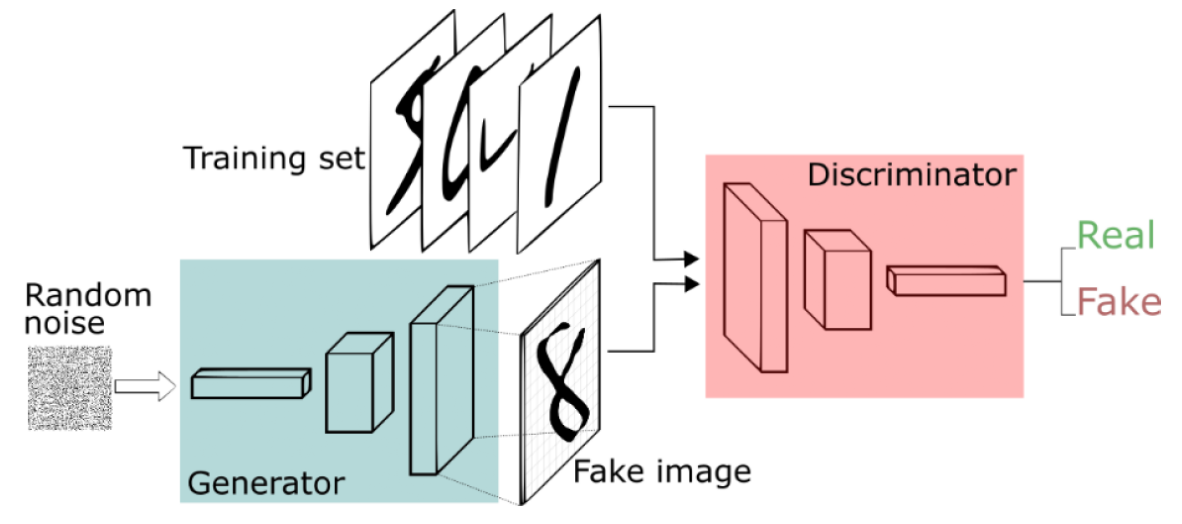

In [ ]:
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
img = mpimg.imread(file_name)
plt.figure(figsize=(15, 25))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Generative Adversarial Network (GAN) adalah arsitektur deep learning yang terdiri dari dua jaringan neural yang saling berkompetisi: Generator dan Discriminator.

2 komponen utama dalam GAN:

1. **Generator**:
   - Generator bertugas untuk menghasilkan gambar palsu yang mirip dengan gambar dalam training set.
   - Input Generator adalah vektor noise acak yang diambil dari distribusi normal atau uniform.
   - Melalui serangkaian lapisan (biasanya lapisan dekonvolusi), Generator mengubah noise ini menjadi gambar yang memiliki dimensi dan karakteristik yang mirip dengan gambar asli dalam training set.

2. **Discriminator**:
   - Discriminator bertugas untuk membedakan antara gambar asli (dari training set) dan gambar palsu (yang dihasilkan oleh Generator).
   - Discriminator adalah jaringan klasifikasi biner yang menerima gambar sebagai input dan menghasilkan skor yang menunjukkan probabilitas bahwa gambar tersebut adalah asli atau palsu.
   - Melalui serangkaian lapisan (biasanya lapisan konvolusi), Discriminator belajar fitur-fitur yang dapat membedakan gambar asli dari yang palsu.

Proses Training GAN:

1. **Inisialisasi**:
   - Generator dan Discriminator diinisialisasi dengan bobot acak.

2. **Forward Pass pada Generator**:
   - Vektor noise acak diberikan sebagai input ke Generator.
   - Generator menghasilkan gambar palsu berdasarkan noise ini.

3. **Forward Pass pada Discriminator**:
   - Discriminator menerima dua jenis input: gambar asli dari training set dan gambar palsu dari Generator.
   - Discriminator memproses kedua jenis gambar ini dan menghasilkan dua skor: satu untuk gambar asli dan satu untuk gambar palsu.
   - Skor untuk gambar asli mendekati 1 (atau label positif), sedangkan skor untuk gambar palsu mendekati 0 (atau label negatif).

4. **Perhitungan Loss**:
   - Loss untuk Discriminator dihitung berdasarkan kemampuannya untuk membedakan gambar asli dari yang palsu.
     - Misalnya, jika `D(real)` adalah output Discriminator untuk gambar asli dan `D(fake)` adalah output untuk gambar palsu, maka loss Discriminator bisa dihitung sebagai:
    
        `Loss_D = -log(D(real)) - log(1 - D(fake))`
      
   - Loss untuk Generator dihitung berdasarkan kemampuan Generator untuk menipu Discriminator agar mengklasifikasikan gambar palsu sebagai gambar asli.
     - Misalnya, loss Generator bisa dihitung sebagai:
        
        `Loss_G = -log(D(fake))`

5. **Backward Pass dan Update Bobot**:
   - Bobot Discriminator diperbarui menggunakan gradien dari loss Discriminator.
   - Bobot Generator diperbarui menggunakan gradien dari loss Generator.

6. **Iterasi**:
   - Langkah-langkah di atas diulangi dalam banyak iterasi. Dengan setiap iterasi, Generator belajar untuk menghasilkan gambar yang lebih realistis, sementara Discriminator belajar untuk menjadi lebih baik dalam membedakan antara gambar asli dan palsu.

Hasil Akhir:

- Setelah banyak iterasi pelatihan, Generator akan mampu menghasilkan gambar palsu yang sangat mirip dengan gambar asli, dan Discriminator akan tetap kesulitan membedakan antara gambar asli dan palsu.
- GAN telah terbukti sangat efektif dalam berbagai aplikasi Generative AI, seperti menghasilkan gambar wajah manusia, seni digital, dan bahkan teks.

Kesimpulan:

GAN bekerja melalui kompetisi antara dua jaringan neural: Generator yang berusaha menipu Discriminator dengan menghasilkan gambar realistis, dan Discriminator yang berusaha untuk membedakan antara gambar asli dan gambar yang dihasilkan oleh Generator. Melalui proses pelatihan adversarial ini, GAN dapat belajar untuk menghasilkan data yang sangat realistis.

# LOAD AND SCALE DATA

### Load the Data

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Print shape dari train dan test data untuk images dan labels nya. Pastikan sudah sesuai dengan data fashion-mnist yang terdiri dari 60,000 training images dan 10,000 training images

In [ ]:
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


Print unique labels untuk dataset train dan test

In [ ]:
print("Unique labels in training set:", np.unique(train_labels))
print("Unique labels in test set:", np.unique(test_labels))

Unique labels in training set: [0 1 2 3 4 5 6 7 8 9]
Unique labels in test set: [0 1 2 3 4 5 6 7 8 9]


Berdasarkan informasi labels dari https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md, diketahui bahwa
T-shirt/top memiliki label 0 dan Trouser memiliki label 1

Melakukan filter hanya untuk class T-shirt/top (0) and Trouser (1) karena NIM Genap dan Gender Laki-laki

In [ ]:
train_filter = np.where((train_labels == 0) | (train_labels == 1))
test_filter = np.where((test_labels == 0) | (test_labels == 1))

train_images, train_labels = train_images[train_filter], train_labels[train_filter]
test_images, test_labels = test_images[test_filter], test_labels[test_filter]

In [ ]:
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (12000, 28, 28)
Train labels shape: (12000,)
Test images shape: (2000, 28, 28)
Test labels shape: (2000,)


Menggabungkan kedua train dan test dataset untuk proses splitting

In [ ]:
all_images = np.concatenate((train_images, test_images), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)

Print shape dari data setelah digabungkan

In [ ]:
print("All data shape:", all_images.shape, all_labels.shape)

All data shape: (14000, 28, 28) (14000,)


### Scale the Data

Gambar dinormalisasi ke rentang [0, 1] setelah dataset dipisahkan. Scaling ini perlu dilakukan agar data berada dalam rentang yang sama, sehingga model GAN dapat lebih mudah dan efisien dalam mengurangi dimensi data. Ini membantu GAN untuk belajar representasi yang lebih baik dan stabil selama pelatihan, mempercepat konvergensi dan meningkatkan kinerja.

In [ ]:
all_images = all_images / 255.0

### Split the Data

Lakukan pengacakan pada dataset untuk memastikan distribusi acak.

In [ ]:
indices = np.arange(all_images.shape[0])
np.random.shuffle(indices)
all_images = all_images[indices]
all_labels = all_labels[indices]

Lakukan Split pada dataset: 80% training, 10% validation, 10% test

In [ ]:
num_train = int(0.8 * all_images.shape[0])
num_val = int(0.1 * all_images.shape[0])

In [ ]:
train_images, train_labels = all_images[:num_train], all_labels[:num_train]
val_images, val_labels = all_images[num_train:num_train + num_val], all_labels[num_train:num_train + num_val]
test_images, test_labels = all_images[num_train + num_val:], all_labels[num_train + num_val:]

Print shape dari data setelah dilakukan split

In [ ]:
print("Training data shape:", train_images.shape, train_labels.shape)
print("Validation data shape:", val_images.shape, val_labels.shape)
print("Testing data shape:", test_images.shape, test_labels.shape)

Training data shape: (11200, 28, 28) (11200,)
Validation data shape: (1400, 28, 28) (1400,)
Testing data shape: (1400, 28, 28) (1400,)


### Display the Data

Membuat function untuk display gambar kedua kelas, masing-masing untuk train, test, dan val

In [ ]:
def display_sample_images(images, labels, title):
    plt.figure(figsize=(6, 3))
    unique_labels = np.unique(labels)
    for i, label in enumerate(unique_labels):
        index = np.where(labels == label)[0][0]
        plt.subplot(1, len(unique_labels), i+1)
        plt.imshow(images[index], cmap='gray')
        plt.title(f"{title} - Class {label}")
        plt.axis('off')
    plt.show()

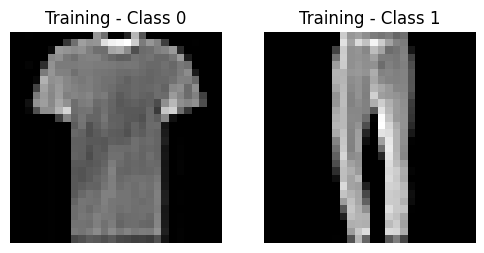

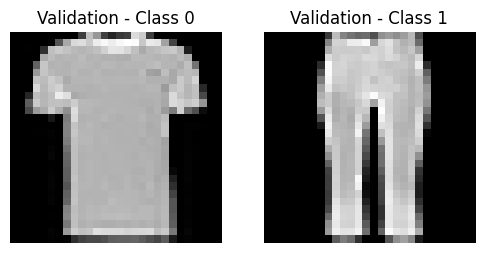

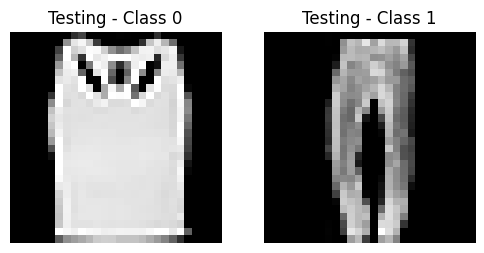

In [ ]:
display_sample_images(train_images, train_labels, "Training")
display_sample_images(val_images, val_labels, "Validation")
display_sample_images(test_images, test_labels, "Testing")

# B. GAN ARCHITECTURE

Saving GANB.png to GANB.png


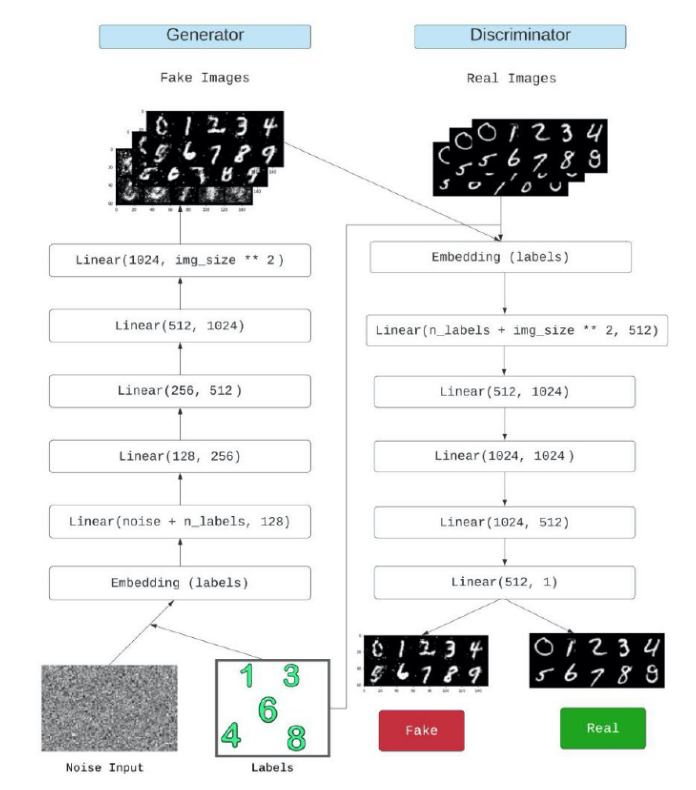

In [ ]:
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
img = mpimg.imread(file_name)
plt.figure(figsize=(20, 10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Cara Kerja Arsitektur cGAN untuk Fashion MNIST

Generator:
1. **Input**:
   - **Noise Input**: Vektor acak (noise) yang digunakan sebagai input utama.
   - **Labels**: Label yang menentukan kategori gambar yang ingin dihasilkan (0 untuk T-Shirt/Top dan 1 untuk Trouser).

2. **Embedding Labels**:
   - Label diberi embedding untuk menghasilkan representasi vektor dari label tersebut.

3. **Kombinasi Input**:
   - Vektor embedding label digabungkan dengan vektor noise untuk membentuk input gabungan.

4. **Jaringan Fully Connected**:
   - Beberapa lapisan fully connected (dense) dengan ukuran yang semakin besar digunakan untuk mengubah input gabungan menjadi gambar.
   - Urutan lapisan:
     - Linear(noise + n_labels, 128)
     - Linear(128, 256)
     - Linear(256, 512)
     - Linear(512, 1024)
     - Linear(1024, img_size ** 2)

5. **Output**:
   - Hasil akhir dari generator adalah gambar palsu yang memiliki dimensi sesuai dengan gambar asli (28x28 untuk Fashion MNIST).

Discriminator:
1. **Input**:
   - **Real Images**: Gambar asli dari dataset.
   - **Labels**: Label yang sesuai dengan gambar asli.

2. **Embedding Labels**:
   - Label diberi embedding untuk menghasilkan representasi vektor dari label tersebut.

3. **Kombinasi Input**:
   - Vektor embedding label digabungkan dengan gambar (diratakan) untuk membentuk input gabungan.

4. **Jaringan Fully Connected**:
   - Beberapa lapisan fully connected (dense) digunakan untuk mengubah input gabungan menjadi satu skor yang menunjukkan apakah gambar asli atau palsu.
   - Urutan lapisan:
     - Linear(n_labels + img_size ** 2, 512)
     - Linear(512, 1024)
     - Linear(1024, 1024)
     - Linear(1024, 512)
     - Linear(512, 1)

5. **Output**:
   - Hasil akhir dari discriminator adalah satu nilai yang menunjukkan apakah gambar adalah asli (real) atau palsu (fake).

Proses Training:
1. **Generator Training**:
   - Generator berusaha menghasilkan gambar yang terlihat nyata berdasarkan noise dan label, untuk menipu discriminator.

2. **Discriminator Training**:
   - Discriminator belajar membedakan antara gambar nyata dari dataset dan gambar palsu yang dihasilkan oleh generator, menggunakan kombinasi gambar dan label.

3. **Adversarial Training**:
   - Generator dan discriminator dilatih secara adversarial, di mana generator berusaha memperbaiki kemampuannya dalam menghasilkan gambar yang realistis, sementara discriminator berusaha meningkatkan kemampuannya dalam membedakan gambar asli dan palsu.

## Reshape the Data

Saya melakukan dimension expansion pada `train_images`, `val_images`, dan `test_images` untuk menambahkan dimensi channel pada gambar. Hal ini dilakukan karena gambar dalam dataset Fashion MNIST awalnya memiliki bentuk `(28, 28)`, sedangkan Convolutional Neural Network (CNN) dalam TensorFlow/Keras mengharapkan input dengan bentuk `(height, width, channels)`.

Dalam kasus gambar grayscale seperti pada dataset Fashion MNIST, jumlah channel adalah 1. Oleh karena itu, bentuk akhir dari gambar harus menjadi `(28, 28, 1)`. Proses ini memastikan bahwa data memiliki bentuk yang benar untuk digunakan sebagai input dalam lapisan konvolusi model autoencoder.

In [ ]:
train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

In [ ]:
print("Training data shape:", train_images.shape)
print("Validation data shape:", val_images.shape)
print("Testing data shape:", test_images.shape)

Training data shape: (11200, 28, 28, 1)
Validation data shape: (1400, 28, 28, 1)
Testing data shape: (1400, 28, 28, 1)


Mengatur dimensi dari input

In [ ]:
latent_dim = 100
num_classes = 2
img_shape = (28, 28, 1)

## Generator

In [ ]:
def build_generator(latent_dim, num_classes):
    noise = layers.Input(shape=(latent_dim,))
    label = layers.Input(shape=(1,), dtype='int32')

    label_embedding = layers.Embedding(num_classes, latent_dim)(label)
    label_embedding = layers.Flatten()(label_embedding)

    model_input = layers.multiply([noise, label_embedding])

    x = layers.Dense(128)(model_input)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dense(np.prod(img_shape), activation='tanh')(x)

    img = layers.Reshape(img_shape)(x)

    return models.Model([noise, label], img)

## Discriminator

In [ ]:
def build_discriminator(img_shape, num_classes):
    img = layers.Input(shape=img_shape)
    label = layers.Input(shape=(1,), dtype='int32')

    flat_image = layers.Flatten()(img)

    label_embedding = layers.Embedding(num_classes, np.prod(img_shape))(label)
    label_embedding = layers.Flatten()(label_embedding)

    model_input = layers.Concatenate()([flat_image, label_embedding])

    x = layers.Dense(512)(model_input)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    validity = layers.Dense(1, activation='sigmoid')(x)

    return models.Model([img, label], validity)

## GAN

Function untuk training model GAN

In [ ]:
def train_gan(epochs, batch_size, latent_dim, train_images, train_labels):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, train_images.shape[0], batch_size)
        imgs, labels = train_images[idx], train_labels[idx]

        labels = labels.reshape(-1, 1)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        gen_imgs = generator.predict([noise, gen_labels], verbose=0)

        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, gen_labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        sampled_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        g_loss = combined.train_on_batch([noise, sampled_labels], real)

        if epoch % 10 == 0:
            print(f"{epoch} [D loss: {d_loss[0]}] [G loss: {g_loss}]")

        if epoch % 50 == 0:
            sample_images(epoch)

def sample_images(epoch, num_examples=10):
    noise = np.random.normal(0, 1, (num_examples, latent_dim))
    sampled_labels = np.array([num for _ in range(num_examples // num_classes) for num in range(num_classes)])
    sampled_labels = sampled_labels.reshape(-1, 1)
    gen_imgs = generator.predict([noise, sampled_labels])

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(1, num_examples, figsize=(20, 4))
    for i in range(num_examples):
        axs[i].imshow(gen_imgs[i, :, :, 0], cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f"Class {sampled_labels[i]}")
    plt.show()

Buat dan Compile Model

In [ ]:
discriminator = build_discriminator(img_shape, num_classes)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])
generator = build_generator(latent_dim, num_classes)

In [ ]:
z = layers.Input(shape=(latent_dim,))
label = layers.Input(shape=(1,), dtype='int32')
img = generator([z, label])
discriminator.trainable = False
valid = discriminator([img, label])
combined = models.Model([z, label], valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(0.0002, 0.5))

Mengubah label menjadi bentuk one-hot encoding

0 [D loss: 0.6600275039672852] [G loss: 0.6807931661605835]
1/1 [==============================] - 0s 82ms/step


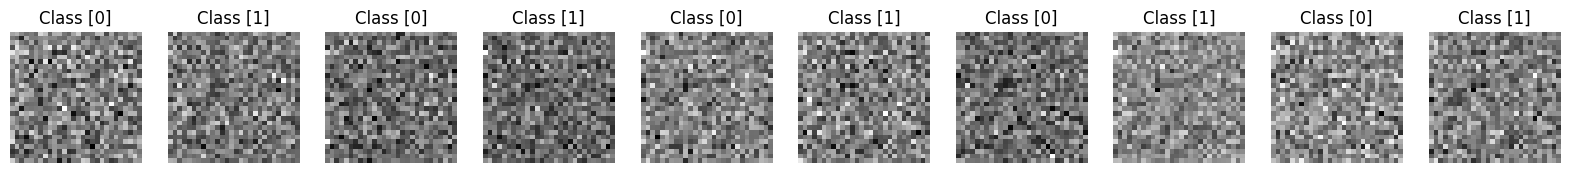

10 [D loss: 0.07343629328534007] [G loss: 2.5700149536132812]
20 [D loss: 0.02261199615895748] [G loss: 7.299938201904297]
30 [D loss: 0.158968941308558] [G loss: 2.744715452194214]
40 [D loss: 0.4715433418750763] [G loss: 2.6137006282806396]
50 [D loss: 0.17278151959180832] [G loss: 3.3190433979034424]
1/1 [==============================] - 0s 19ms/step


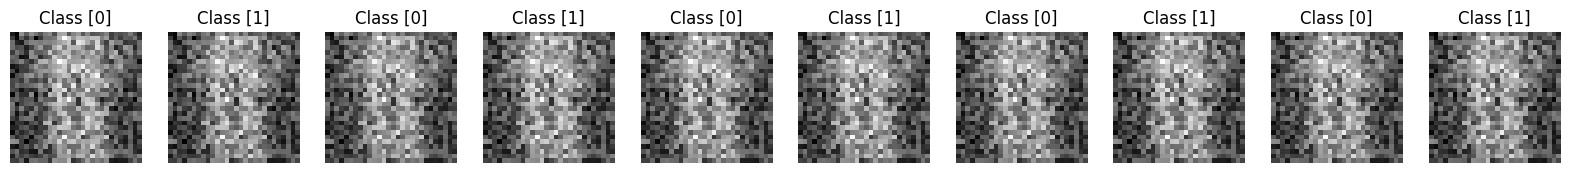

60 [D loss: 2.486958682537079] [G loss: 1.143733263015747]
70 [D loss: 0.24536526575684547] [G loss: 2.8912124633789062]
80 [D loss: 0.2129811942577362] [G loss: 3.3664917945861816]
90 [D loss: 0.11647865921258926] [G loss: 3.448963165283203]
100 [D loss: 0.08340809494256973] [G loss: 3.5236032009124756]
1/1 [==============================] - 0s 20ms/step


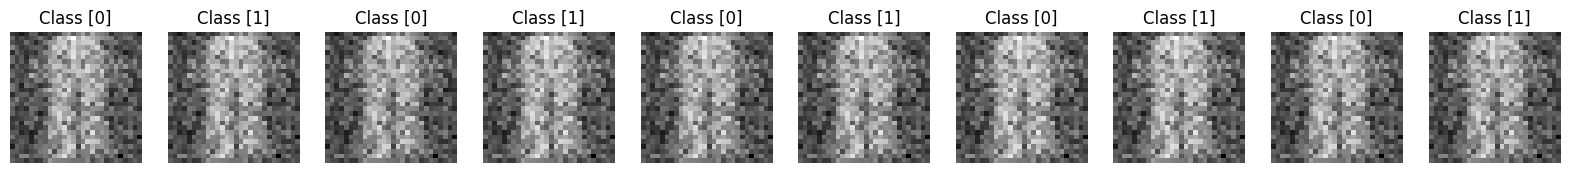

110 [D loss: 0.1136592268012464] [G loss: 3.718806266784668]
120 [D loss: 0.11630316078662872] [G loss: 2.6010446548461914]
130 [D loss: 0.317110151052475] [G loss: 4.419121742248535]
140 [D loss: 0.11830491200089455] [G loss: 3.802733898162842]
150 [D loss: 0.06459946557879448] [G loss: 4.881113529205322]
1/1 [==============================] - 0s 18ms/step


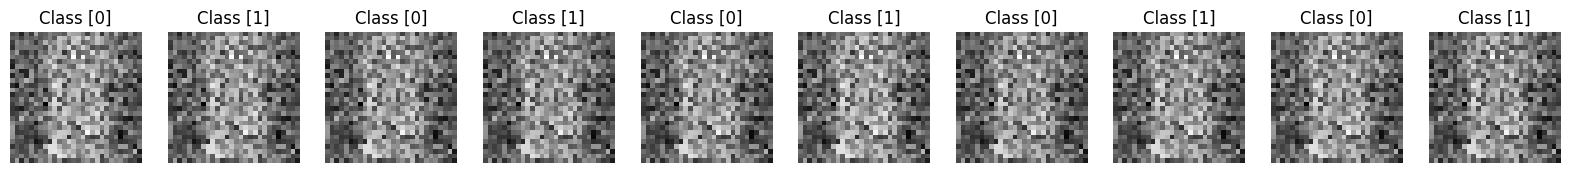

160 [D loss: 0.17069483920931816] [G loss: 3.713955879211426]
170 [D loss: 0.11269869620446116] [G loss: 7.614155292510986]
180 [D loss: 0.14611263573169708] [G loss: 3.199256658554077]
190 [D loss: 0.14926553517580032] [G loss: 4.684751033782959]
200 [D loss: 0.04115357622504234] [G loss: 4.178438663482666]
1/1 [==============================] - 0s 18ms/step


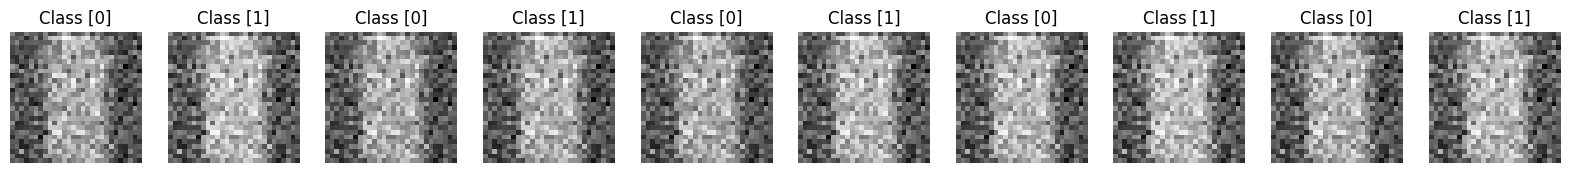

210 [D loss: 0.07018485991284251] [G loss: 5.687988758087158]
220 [D loss: 0.009827890899032354] [G loss: 5.860023021697998]
230 [D loss: 0.20110930036753416] [G loss: 10.78445816040039]
240 [D loss: 0.07565967226400971] [G loss: 4.912730693817139]
250 [D loss: 0.1549268737435341] [G loss: 3.8275978565216064]
1/1 [==============================] - 0s 29ms/step


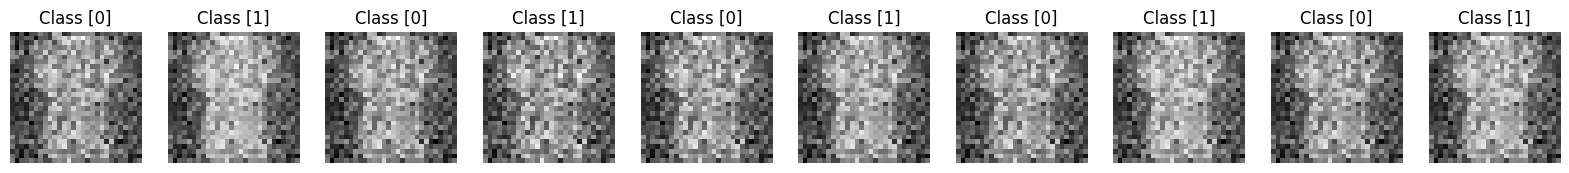

260 [D loss: 0.06321218609809875] [G loss: 5.504947662353516]
270 [D loss: 0.06220272183418274] [G loss: 5.931149482727051]
280 [D loss: 0.42801354825496674] [G loss: 5.50934362411499]
290 [D loss: 0.19700171053409576] [G loss: 4.273197174072266]
300 [D loss: 0.09282033890485764] [G loss: 4.137723922729492]
1/1 [==============================] - 0s 18ms/step


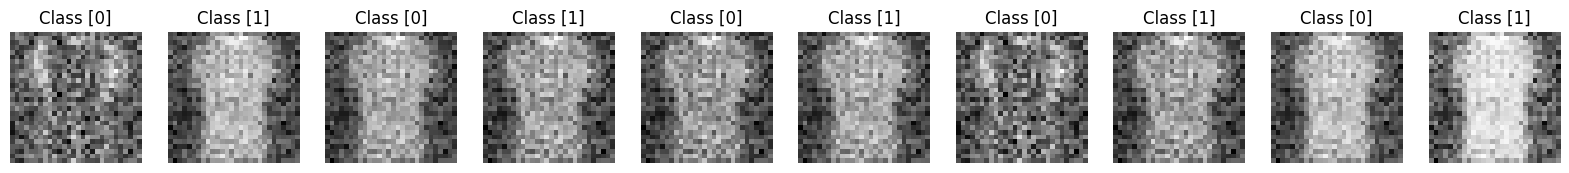

310 [D loss: 0.12368756905198097] [G loss: 4.446831226348877]
320 [D loss: 0.20154181867837906] [G loss: 3.2510271072387695]
330 [D loss: 0.3283505439758301] [G loss: 4.617279052734375]
340 [D loss: 0.1967933475971222] [G loss: 3.14255690574646]
350 [D loss: 0.6118963658809662] [G loss: 3.3772943019866943]
1/1 [==============================] - 0s 25ms/step


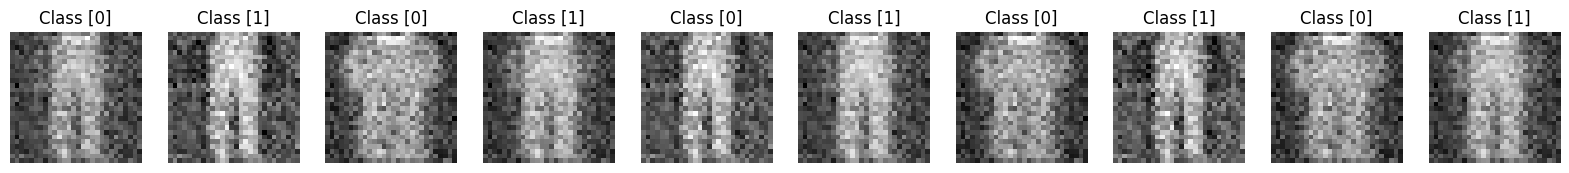

360 [D loss: 0.15741368383169174] [G loss: 2.847757577896118]
370 [D loss: 0.2955777496099472] [G loss: 3.5107789039611816]
380 [D loss: 0.2453027218580246] [G loss: 3.168987274169922]
390 [D loss: 0.25361868739128113] [G loss: 3.43569016456604]
400 [D loss: 0.4164070188999176] [G loss: 2.291890859603882]
1/1 [==============================] - 0s 18ms/step


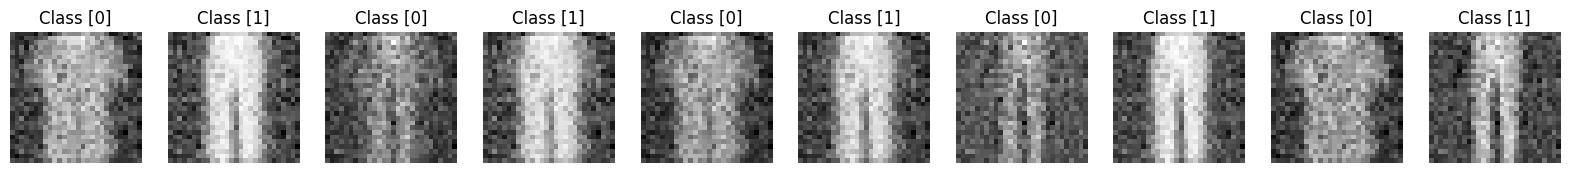

410 [D loss: 0.3748957887291908] [G loss: 2.5037834644317627]
420 [D loss: 0.2704211175441742] [G loss: 2.902106285095215]
430 [D loss: 0.2602982446551323] [G loss: 2.9936139583587646]
440 [D loss: 0.18866101652383804] [G loss: 3.3514957427978516]
450 [D loss: 0.12262605875730515] [G loss: 3.1070704460144043]
1/1 [==============================] - 0s 27ms/step


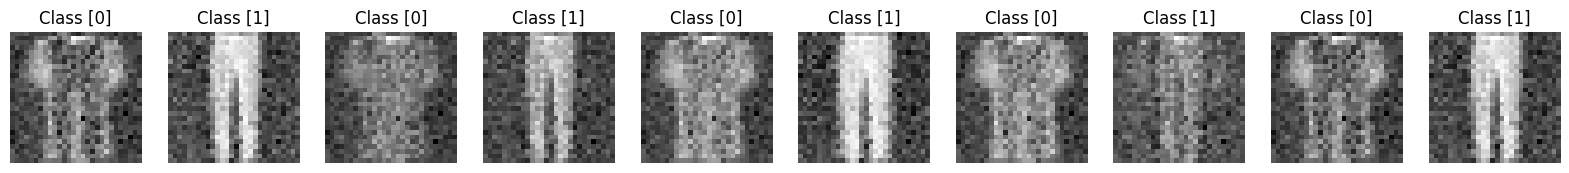

460 [D loss: 0.17215757817029953] [G loss: 3.259132146835327]
470 [D loss: 0.19484013505280018] [G loss: 3.712948799133301]
480 [D loss: 0.36162641644477844] [G loss: 2.587265968322754]
490 [D loss: 0.08692305721342564] [G loss: 3.536807060241699]
500 [D loss: 0.32574062049388885] [G loss: 2.197039842605591]
1/1 [==============================] - 0s 18ms/step


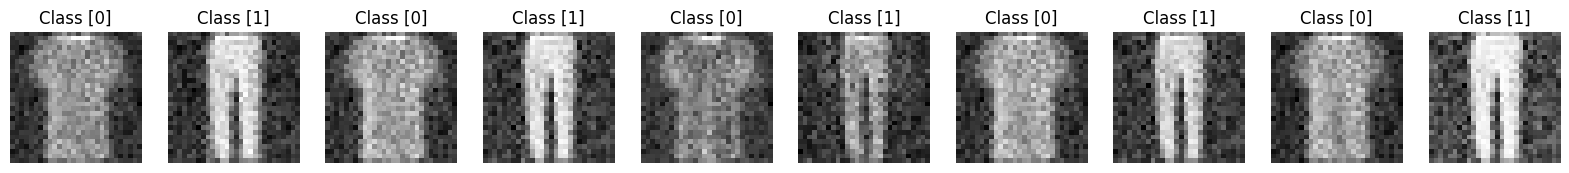

510 [D loss: 0.1275978982448578] [G loss: 2.871561050415039]
520 [D loss: 0.21398581564426422] [G loss: 4.178991317749023]
530 [D loss: 0.18068571016192436] [G loss: 3.2681832313537598]
540 [D loss: 0.1409960542805493] [G loss: 3.676896572113037]
550 [D loss: 0.7745286822319031] [G loss: 3.2332279682159424]
1/1 [==============================] - 0s 29ms/step


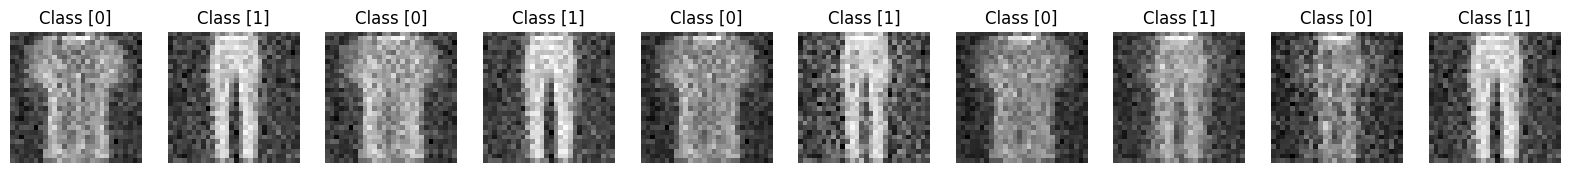

560 [D loss: 0.2791953682899475] [G loss: 3.6855528354644775]
570 [D loss: 0.29971490800380707] [G loss: 3.7759575843811035]
580 [D loss: 0.18001616327092052] [G loss: 5.0868682861328125]
590 [D loss: 0.3094533085823059] [G loss: 4.006877899169922]
600 [D loss: 0.12317084521055222] [G loss: 3.8516149520874023]
1/1 [==============================] - 0s 17ms/step


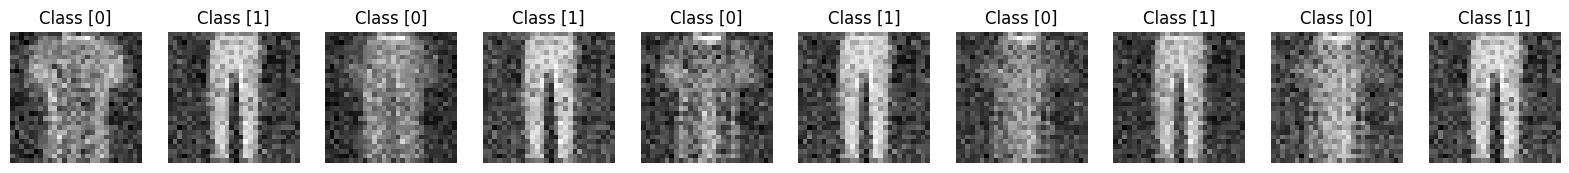

610 [D loss: 0.2327190339565277] [G loss: 4.996646881103516]
620 [D loss: 0.16310695558786392] [G loss: 4.655465126037598]
630 [D loss: 0.19908513501286507] [G loss: 3.099708080291748]
640 [D loss: 0.10916543751955032] [G loss: 3.8547658920288086]
650 [D loss: 0.17647413909435272] [G loss: 4.313060760498047]
1/1 [==============================] - 0s 25ms/step


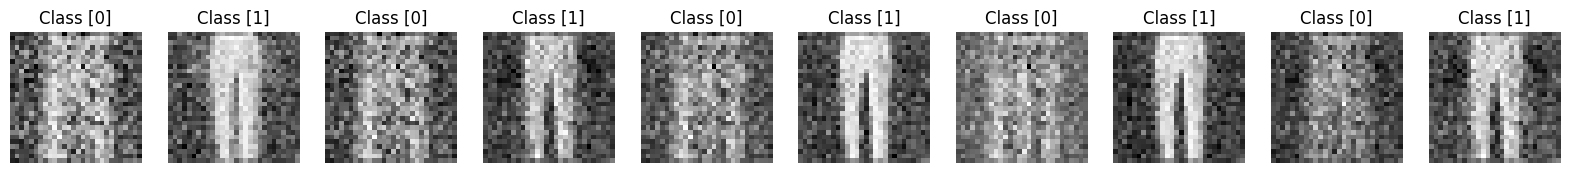

660 [D loss: 0.31857628375291824] [G loss: 2.828242540359497]
670 [D loss: 0.15674446523189545] [G loss: 3.8891048431396484]
680 [D loss: 0.09469584003090858] [G loss: 3.898843765258789]
690 [D loss: 0.07182690594345331] [G loss: 5.688793182373047]
700 [D loss: 0.16521066427230835] [G loss: 3.6345016956329346]
1/1 [==============================] - 0s 81ms/step


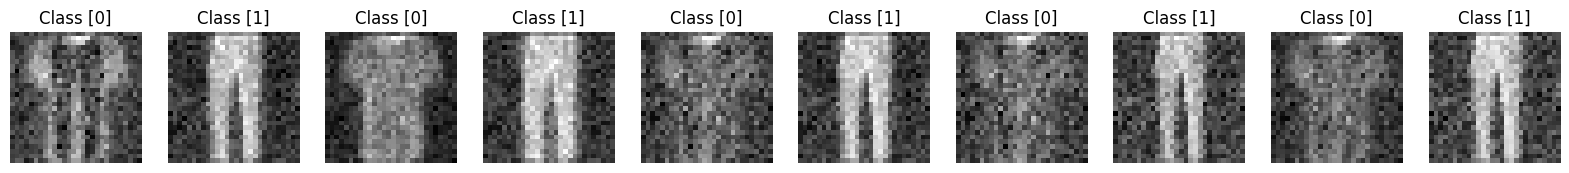

710 [D loss: 0.5842979103326797] [G loss: 7.02099609375]
720 [D loss: 0.23274575918912888] [G loss: 3.2294435501098633]
730 [D loss: 0.3494778275489807] [G loss: 5.336093902587891]
740 [D loss: 0.2916451692581177] [G loss: 3.1942238807678223]
750 [D loss: 0.61100272834301] [G loss: 4.620726108551025]
1/1 [==============================] - 0s 18ms/step


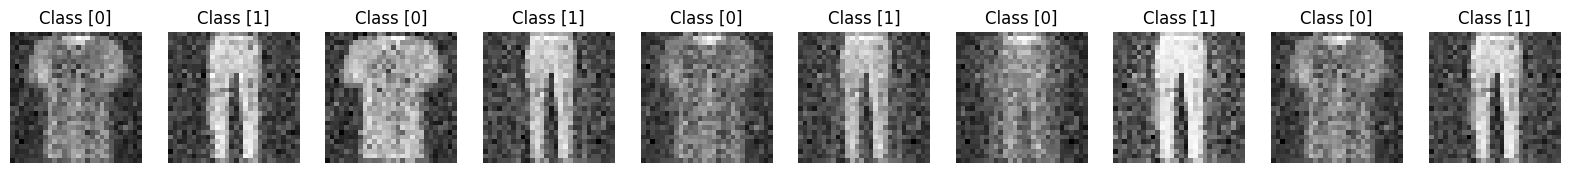

760 [D loss: 0.14459146559238434] [G loss: 3.5469233989715576]
770 [D loss: 0.14484356716275215] [G loss: 4.751961708068848]
780 [D loss: 0.23296046257019043] [G loss: 3.66707444190979]
790 [D loss: 0.5554216951131821] [G loss: 2.61832857131958]
800 [D loss: 0.2220788262784481] [G loss: 3.381993532180786]
1/1 [==============================] - 0s 18ms/step


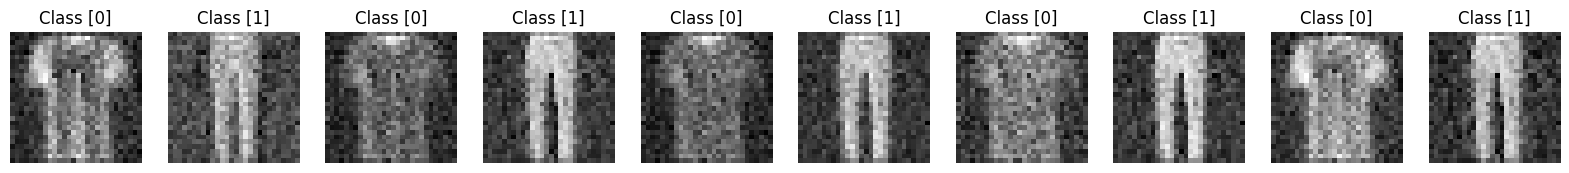

810 [D loss: 0.3320583999156952] [G loss: 3.554635524749756]
820 [D loss: 0.28565381467342377] [G loss: 3.42405366897583]
830 [D loss: 0.15072856843471527] [G loss: 3.680773973464966]
840 [D loss: 0.37675999104976654] [G loss: 3.910073757171631]
850 [D loss: 0.7467978596687317] [G loss: 3.534585475921631]
1/1 [==============================] - 0s 17ms/step


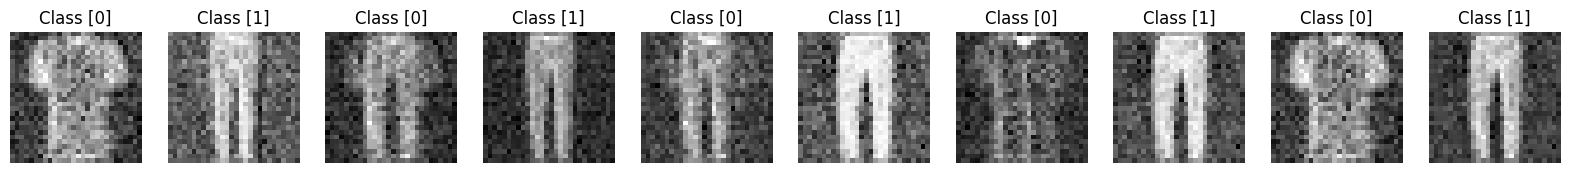

860 [D loss: 0.14072174206376076] [G loss: 3.663433074951172]
870 [D loss: 0.1538713052868843] [G loss: 3.5242936611175537]
880 [D loss: 0.2242402359843254] [G loss: 2.8569960594177246]
890 [D loss: 0.37874218076467514] [G loss: 2.9392995834350586]
900 [D loss: 0.2596605196595192] [G loss: 3.6840076446533203]
1/1 [==============================] - 0s 18ms/step


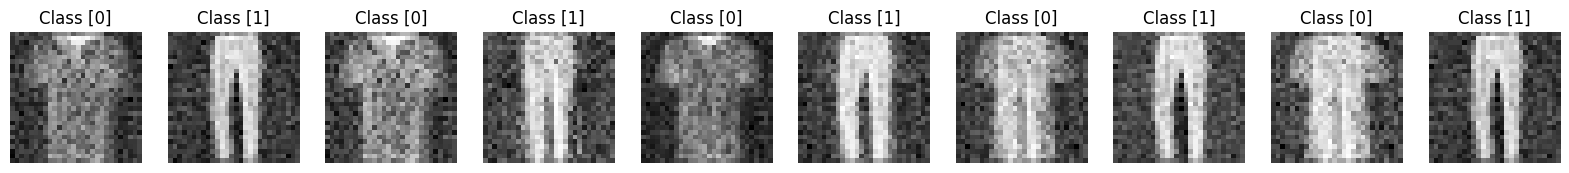

910 [D loss: 0.16915038973093033] [G loss: 3.5401666164398193]
920 [D loss: 0.25598379224538803] [G loss: 3.5367462635040283]
930 [D loss: 0.605430856347084] [G loss: 3.068143367767334]
940 [D loss: 0.2704286128282547] [G loss: 2.6358070373535156]
950 [D loss: 0.45047688484191895] [G loss: 3.368464946746826]
1/1 [==============================] - 0s 18ms/step


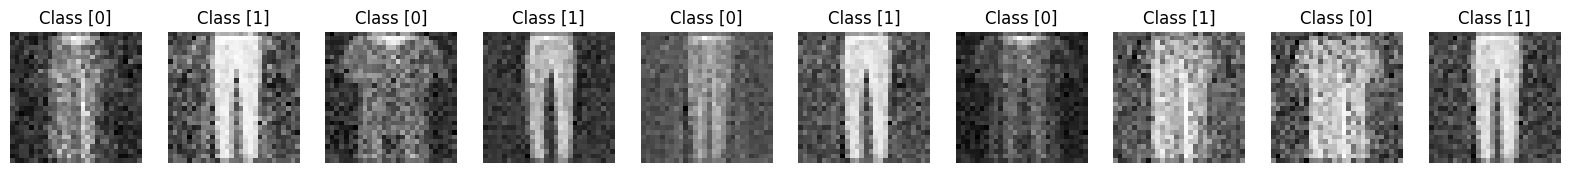

960 [D loss: 0.22154606878757477] [G loss: 3.6933066844940186]
970 [D loss: 0.23578116297721863] [G loss: 3.8541486263275146]
980 [D loss: 0.33522942662239075] [G loss: 4.715975284576416]
990 [D loss: 0.28481779247522354] [G loss: 4.302831172943115]


In [ ]:
train_gan(epochs=1000, batch_size=64, latent_dim=latent_dim, train_images=train_images, train_labels=train_labels)

Hasil training menunjukkan evolusi performa model GAN selama beberapa epoch. Di awal training, D loss dan G loss menunjukkan variabilitas yang tinggi, dengan nilai G loss yang sangat tinggi menunjukkan bahwa Generator kesulitan menipu Discriminator. Seiring dengan peningkatan epoch, D loss menurun dan lebih stabil, sementara G loss juga menjadi lebih stabil tetapi tetap menunjukkan fluktuasi yang signifikan.

Visualisasi gambar yang dihasilkan menunjukkan perbaikan bertahap dalam kualitas gambar. Di awal training, gambar yang dihasilkan terlihat sangat buram dan tidak jelas. Namun, seiring dengan bertambahnya epoch, gambar yang dihasilkan menjadi lebih jelas dan mulai menunjukkan karakteristik yang lebih mendekati gambar asli dari dataset Fashion MNIST untuk kategori "T-shirt/top" (Class 0) dan "Trouser" (Class 1). Meski demikian, masih terdapat noise dan beberapa gambar yang belum sepenuhnya realistis.

## Evaluation: Fréchet Inception Distance (FID)

Fréchet Inception Distance (FID) adalah metrik yang mengukur seberapa mirip gambar yang dihasilkan oleh GAN dengan gambar asli. FID menghitung jarak antara distribusi fitur dari gambar asli dan gambar yang dihasilkan, menggunakan fitur yang diekstrak oleh model InceptionV3.

Mengapa FID Digunakan?
- FID menilai kualitas gambar berdasarkan seberapa realistis dan mirip dengan gambar asli.
- FID membandingkan keseluruhan distribusi fitur, bukan hanya gambar individual.
- FID dapat mendeteksi artefak dan noise dalam gambar yang dihasilkan.

Mengapa Inception V3 Dipilih?
- Inception V3 adalah model yang sudah dilatih secara ekstensif pada dataset besar seperti ImageNet, membuatnya sangat efektif dalam mengekstraksi fitur tingkat tinggi dari gambar.
- Inception V3 telah menjadi standar de facto untuk evaluasi FID, memungkinkan perbandingan yang konsisten dan diterima secara luas dalam penelitian GAN.
- Model ini memiliki arsitektur yang dalam dan kompleks, memungkinkan pengenalan pola yang lebih baik dalam gambar, sehingga memberikan evaluasi yang lebih akurat tentang kualitas gambar yang dihasilkan oleh GAN.

FID digunakan karena memberikan penilaian akurat dan komprehensif tentang kemampuan GAN dalam menghasilkan gambar yang realistis dan sesuai dengan data asli, dengan Inception V3 sebagai alat yang kuat dan terpercaya untuk ekstraksi fitur.

Menghasilkan sejumlah gambar menggunakan generator yang sudah dilatih.


In [ ]:
def generate_images(generator, latent_dim, num_examples, num_classes):
    noise = np.random.normal(0, 1, (num_examples, latent_dim))
    sampled_labels = np.array([num for _ in range(num_examples // num_classes) for num in range(num_classes)])
    sampled_labels = sampled_labels.reshape(-1, 1)
    gen_imgs = generator.predict([noise, sampled_labels])
    return gen_imgs, sampled_labels

Function untuk FID calculation

In [ ]:
def calculate_fid(real_images, generated_images):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))

    real_images = preprocess_input(real_images)
    generated_images = preprocess_input(generated_images)

    act_real = model.predict(real_images)
    act_generated = model.predict(generated_images)

    mu_real, sigma_real = act_real.mean(axis=0), np.cov(act_real, rowvar=False)
    mu_generated, sigma_generated = act_generated.mean(axis=0), np.cov(act_generated, rowvar=False)

    ssdiff = np.sum((mu_real - mu_generated) ** 2.0)
    covmean = sqrtm(sigma_real.dot(sigma_generated))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_generated - 2.0 * covmean)
    return fid

Menghasilkan gambar dari generator dan menghitung FID menggunakan gambar test dari dataset Fashion MNIST.

In [ ]:
num_examples = 1000
generated_images, gen_labels = generate_images(generator, latent_dim, num_examples, num_classes)

generated_images = 0.5 * generated_images + 0.5
generated_images_rgb = np.repeat(generated_images, 3, axis=-1)

generated_images_rgb_resized = np.array([tf.image.resize(img, (75, 75)).numpy() for img in generated_images_rgb])

32/32 [==============================] - 0s 2ms/step


Menyiapkan gambar test asli

In [ ]:
test_images_rgb = np.repeat(test_images[:num_examples], 3, axis=-1)
test_images_rgb_resized = np.array([tf.image.resize(img, (75, 75)).numpy() for img in test_images_rgb])

Menghitung FID

In [ ]:
fid = calculate_fid(test_images_rgb_resized, generated_images_rgb_resized)
print("FID Score:", fid)

32/32 [==============================] - 4s 23ms/step
FID Score: 7.984748986628795 


Nilai Frechet Inception Distance (FID) sebesar 7.984748986628795 menunjukkan bahwa gambar yang dihasilkan oleh model GAN memiliki tingkat kesamaan yang cukup baik dengan gambar asli dari dataset Fashion MNIST. Meskipun nilai FID di bawah 10 umumnya dianggap sebagai indikasi kualitas yang baik dalam konteks evaluasi GAN, hasil ini juga menunjukkan bahwa masih ada ruang untuk perbaikan. Gambar yang dihasilkan sudah cukup mirip dengan gambar asli dalam hal distribusi fitur, namun kualitas visual gambar masih bisa ditingkatkan, terutama dalam hal ketajaman dan pengurangan noise. Secara keseluruhan, nilai FID ini menunjukkan bahwa model GAN berada di jalur yang benar, tetapi masih memerlukan penyempurnaan lebih lanjut untuk menghasilkan gambar yang lebih realistis dan berkualitas tinggi.

## Visualization

In [ ]:
def plot_images(original_images, generated_images, labels, num_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Display original images
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title(f"Original: {labels[i]}")

        # Display generated images
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title(f"Generated: {labels[i]}")
    plt.show()

Generate gambar menggunakan trained generator

In [ ]:
num_samples = 10
sampled_labels = np.array([0, 1] * (num_samples // 2)).reshape(-1, 1)
noise = np.random.normal(0, 1, (num_samples, latent_dim))
generated_images = generator.predict([noise, sampled_labels])

1/1 [==============================] - 0s 19ms/step


Ambil original images dari test set

In [ ]:
original_images = []
original_labels = []
for label in sampled_labels:
    index = np.where(test_labels == label[0])[0][0]
    original_images.append(test_images[index])
    original_labels.append(label[0])

original_images = np.array(original_images)
original_labels = np.array(original_labels)

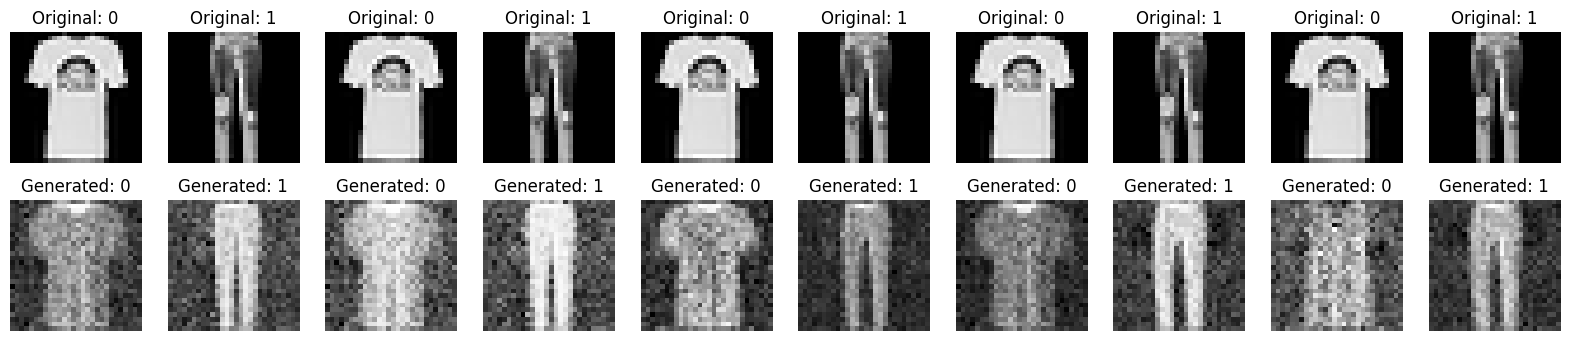

In [ ]:
plot_images(original_images, generated_images, original_labels, num_images=num_samples)

Hasil visualisasi di atas menunjukkan bahwa model GAN berhasil menghasilkan gambar yang sesuai dengan kategori yang diberikan, yaitu T-shirt/top (label 0) dan Trouser (label 1). Gambar-gambar yang dihasilkan oleh model GAN (baris bawah) memiliki fitur dasar yang mirip dengan gambar asli (baris atas), namun kualitasnya masih kurang baik, terlihat buram dan ada noise.

1/1 [==============================] - 0s 32ms/step


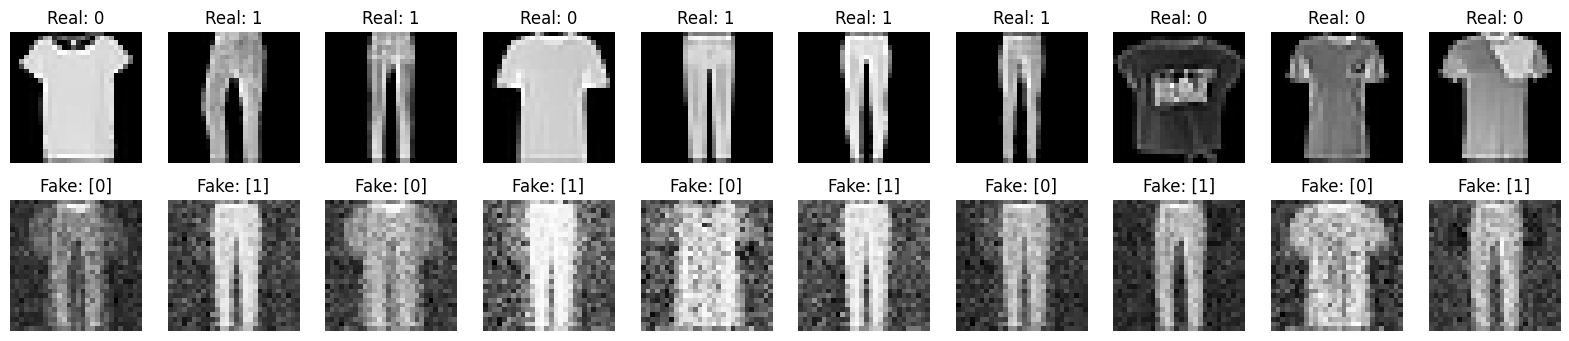

In [ ]:
def visualize_real_and_fake(real_images, fake_images, real_labels, fake_labels, num_examples=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_examples):
        # Display real images
        ax = plt.subplot(2, num_examples, i + 1)
        plt.imshow(real_images[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title(f"Real: {real_labels[i]}")

        # Display fake images
        ax = plt.subplot(2, num_examples, i + 1 + num_examples)
        plt.imshow(fake_images[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title(f"Fake: {fake_labels[i]}")
    plt.show()

num_samples = 10
sampled_labels = np.array([0, 1] * (num_samples // 2)).reshape(-1, 1)
noise = np.random.normal(0, 1, (num_samples, latent_dim))
generated_images = generator.predict([noise, sampled_labels])
generated_images = 0.5 * generated_images + 0.5

real_images = train_images[:num_samples]
real_labels = train_labels[:num_samples]

visualize_real_and_fake(real_images, generated_images, real_labels, sampled_labels)

Fake[0]:
- Gambar dengan label ini dihasilkan oleh Generator untuk menyerupai T-shirt/top (label "0").
- Dapat dilihat beberapa contoh gambar "Fake[0]" yang berusaha meniru tampilan umum T-shirt/top.

Fake[1]:
- Gambar dengan label ini dihasilkan oleh Generator untuk menyerupai Trouser (label "1").
- Dapat dilihat beberapa contoh gambar "Fake[1]" yang berusaha meniru tampilan umum Trouser.

Dengan memvisualisasikan gambar asli (Real) dan gambar yang dihasilkan (Fake) secara berdampingan, saya dapat secara langsung membandingkan kualitas dan realisme gambar yang dihasilkan oleh model GAN terhadap gambar asli dari dataset. Ini membantu untuk mengevaluasi sejauh mana model GAN mampu meniru karakteristik dan detail dari gambar asli.

Visualisasi ini menunjukkan bahwa model GAN dapat menghasilkan gambar yang sesuai dengan kategori yang diberikan (T-shirt/top dan Trouser), tetapi kualitas visual gambar yang dihasilkan masih jauh dari sempurna. Gambar fake cenderung buram dan berisik dibandingkan dengan gambar real, menunjukkan bahwa meskipun model telah mempelajari fitur dasar dari data asli, masih diperlukan perbaikan untuk mencapai kualitas gambar yang lebih tinggi. Dengan membandingkan gambar real dan fake, kita dapat melihat area spesifik di mana model GAN perlu ditingkatkan, seperti ketajaman dan detail tekstur.

### Conclusion

Secara keseluruhan, model GAN yang telah dilatih menunjukkan kemampuan yang baik dalam memahami dan menghasilkan gambar berdasarkan kategori yang diberikan. Nilai FID yang diperoleh menunjukkan bahwa model menghasilkan gambar dengan kesamaan fitur yang cukup baik dengan gambar asli. Namun, kualitas gambar yang dihasilkan masih perlu ditingkatkan, terutama dalam hal ketajaman dan pengurangan noise. Visualisasi hasil menunjukkan bahwa model berada di jalur yang benar tetapi memerlukan perbaikan lebih lanjut untuk mencapai kualitas gambar yang lebih tinggi dan realistis. Ini dapat dicapai melalui tuning hyperparameter, memperpanjang waktu pelatihan, atau memperbaiki arsitektur model untuk kedepannya.